# RNNs \#2: Tarea

| Cristóbal Eyzaguirre |  | ceyzaguirre4@uc.cl |  | https://ceyzaguirre4.github.io |
| :---: | :---: | :---: | :---: | :---: |


<br> 

The following code is the same as the first half of the appropiate lab.
The only major changes were done to the decoder to add **teacher forcing**.

Additional changes were added to other modules so as to allow the passing of the correct answer to the decoder module.

Your homework is to run this notebook and compare and comment on the training results (primarily convergence times) between using and not using teacher forcing.



# Import Base Dependencies

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
try:
    from tqdm.notebook import tqdm, trange
except:
    from tqdm import tqdm, trange

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext import data, datasets, vocab

In [3]:
# for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using {DEVICE}')

using cuda


# General Utilities

In [5]:
def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Sequence to sequence (seq2seq): Translation

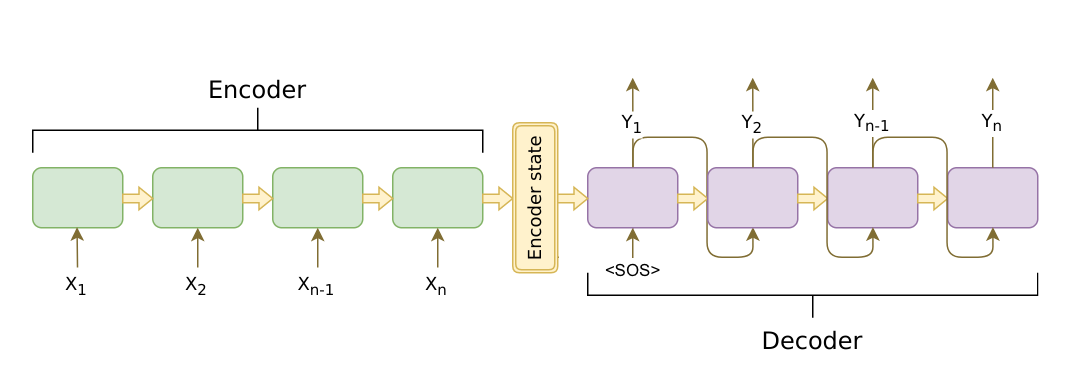

based on [tutorials.pytorch](https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_intro/)

## Encoder

Pretty much the same encoder as in the first part (sentiment analysis).
We embedd the input words and then pass them through a bi-directional LSTM.
The last hidden-state will be used to condition the decoder on the input sequence.

In [6]:
class EncoderModule(nn.Module):
    def __init__(self, embedding_size, hidden_size, source_vocab_size):
        super().__init__()
        self.embeddings_table = nn.Embedding(source_vocab_size,
                                             embedding_size,
                                             padding_idx=0)
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=embedding_size,
                            hidden_size=hidden_size,
                            bidirectional=True,
                            batch_first=True)

    # forward pass
    def forward(self, src_sentences):
        """
        src_sentences shape (batch, seq_len)
        """
        # embed input sequences (batch, seq_len, embed_size)
        embedded = self.embeddings_table(src_sentences)

        # run lstm on full input sequence Tuple(Tensor, Tensor)
        _, hidden_state = self.lstm(embedded)

        return hidden_state

## Decoder

- In order to decode multiple words we will predict one word at a time using a LSTM cell.
  In **pseudo-code**:

    ~~~python
    predicted_words = []
    for word_idx in range(max_output_len):
        prediction = model.predict()
        predicted_words.append(prediction)

    return predicted_words
    ~~~

- To condition the decoder on the input sequence we will use the last hidden-state of the encoder as the first hidden-state of the decoder.

### <b><u>TEACHER FORCING</u></b>

Before the decoder received the last predicted word as input.
However, this time we will do this differently:
- during **training** we will use the correct word rather than the prediction.
  This is called **teacher forcing** and helps with convergence times.
- during **evaluation/test** we use the models prediction.

As before, the first iteration will receive a special `<SOS>` (start of sentence) token.

In [7]:
class DecoderModule(nn.Module):
    def __init__(self, embedding_size, hidden_size, start_idx, dst_vocab_size):
        super().__init__()
        self.embeddings_table = nn.Embedding(dst_vocab_size,
                                             embedding_size,
                                             padding_idx=0)
        self.start_idx = torch.tensor(start_idx).to(DEVICE)
        self.hidden_size = hidden_size

        self.h2o = torch.nn.Linear(hidden_size, dst_vocab_size)
        self.lstm_cell = torch.nn.LSTMCell(input_size=embedding_size,
                                           hidden_size=hidden_size)

    # forward pass
    def forward(self, encoder_hidden_state, max_output_length, correct_answer=None):
        """
        encoder_hidden_state: Tuple(
            Tensor: (batch, hidden_size)
            Tensor: (batch, hidden_size)
        )
        max_output_length: int

        returns Tensor: (batch, max_output_length, dst_vocab_size)
        """
        batch_size = encoder_hidden_state[0].shape[0]

        out = []
        # initial decoder hidden state is final encoder hidden state
        state = encoder_hidden_state
        
        # decoding loop (decode one output word at a time)
        y_t = self.embeddings_table(self.start_idx.repeat(batch_size))
        for i in range(max_output_length):
            state  = self.lstm_cell(y_t, state)

            # calculate output probs (batch, dst_vocab_size)
            P_t = self.h2o(state[0])
            out.append(P_t)

            if not self.training:
                # run as normal
                _, max_indices = P_t.max(dim=1)
                y_t = self.embeddings_table(max_indices)
            else:
                # teacher forcing during training
                y_t = self.embeddings_table(correct_answer[:,i])

        return torch.stack(out, dim=1)

## Data

SCAN dataset ([link](https://github.com/brendenlake/SCAN))

Translates english commands to robot actions:

| Input |   | Output |
| --- | --- | --- |
| jump	|| JUMP |
| jump left	|| LTURN JUMP|
| jump around right	|| RTURN JUMP RTURN JUMP RTURN JUMP RTURN JUMP |


### Download dataset

In [8]:
import requests

BASE_PATH = 'https://gist.githubusercontent.com/ceyzaguirre4/707273ad9fc1729ebe2daac442a8f5a8/raw/'

def download_scan(split):
    filename = f'{split}.txt'
    url = BASE_PATH + filename
    response = requests.get(url)

    with open(filename, 'w') as out_file:
        out_file.write(response.text)

download_scan('tasks_test_simple')
download_scan('tasks_train_simple')

In [9]:
!head tasks_test_simple.txt

turn opposite right thrice and turn opposite left	I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT
run right twice after walk right twice	I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN
look around right twice and turn left thrice	I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT
jump around left thrice and run right thrice	I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN
run thrice and walk opposite left	I_RUN I_RUN I_RUN I_TURN_LEFT I_TURN_LEFT I_WALK
jump opposite right after walk around right thrice	I_TURN_RIGHT I_WALK I_TURN

### Load data

In [10]:
# convert text into tokens
def tokenize(text):
    return text.strip().lower().split()

In [11]:
SOURCE = data.Field(tokenize=tokenize, unk_token=None, batch_first=True)
TARGET = data.Field(tokenize=tokenize, unk_token=None, batch_first=True)

train, test = data.TabularDataset.splits(".",
                                         train="tasks_train_simple.txt",
                                         test="tasks_test_simple.txt",
                                         format="tsv",
                                         fields=[
                                                 ("source", SOURCE), 
                                                 ("target", TARGET)],
                                         skip_header=False)

SOURCE.build_vocab(train)
TARGET.build_vocab(train)

train_iter, test_iter = data.BucketIterator.splits((train, test), 
                                                   batch_sizes=(128, 128),
                                                   device=DEVICE,
                                                   sort_key=lambda x: len(x.target))

## Train Utils

In [12]:
def train_one_epoch(model, dataloader, optimizer, history):
    model.train()
    for batch in dataloader:
        # forward pass
        y_gt = batch.target
        batch_size, max_ouput_len = batch.target.shape
        y_pred = model(batch.source, max_ouput_len, y_gt)
 
        loss = F.cross_entropy(y_pred.flatten(end_dim=-2),
                               y_gt.view(-1))

        history['train_loss'].append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [13]:
def eval_one_epoch(model, dataloader, optimizer, history):
    model.eval()
    history['eval_acc'].append(0)
    history['eval_loss'].append(0)
    with torch.no_grad():
        for batch in dataloader:
            # forward pass
            y_gt = batch.target
            batch_size, max_ouput_len = batch.target.shape
            y_pred = model(batch.source, max_ouput_len)
    
            loss = F.cross_entropy(y_pred.flatten(end_dim=-2),
                                y_gt.view(-1))
            accuracy = (y_pred.argmax(dim=2) == y_gt).float().mean()

            history['eval_acc'][-1] += (accuracy / len(dataloader)).item()
            history['eval_loss'][-1] += (loss / len(dataloader)).item()

In [14]:
def train_model(model, train_dataloader, test_dataloader, optimizer, epochs):
    history = defaultdict(list)
    for epoch in trange(epochs):
        train_one_epoch(model, train_dataloader, optimizer, history)
        eval_one_epoch(model, test_dataloader, optimizer, history)
    return history

## Full Model

In [15]:
class SeqToSeq(nn.Module):
    def __init__(self, embedding_size, hidden_size, source_vocab_size, dest_vocab_size, start_idx):
        super().__init__()
        self.hidden_size = hidden_size

        self.encoder = EncoderModule(embedding_size, hidden_size, source_vocab_size)
        self.decoder = DecoderModule(embedding_size, 2*hidden_size, start_idx, dest_vocab_size)

    def reshape_enc_states(self, enc_hidden_states):
        """
        enc_hidden_states: Tuple(
            hidden_state: Tensor (2, batch, hidden_size)
            cell_state: Tensor (2, batch, hidden_size)
        )

        returns Tuple(
            hidden_state: Tensor (batch, 2*hidden_size)
            cell_state: Tensor (batch, 2*hidden_size)
        )
        """
        def _reshape_enc_state(enc_hidden_state):
            enc_hidden_state = enc_hidden_state\
                .permute(1, 0, 2)\
                .reshape(-1, 2*self.hidden_size)
            return enc_hidden_state

        hidden_state, cell_state = enc_hidden_states

        hidden_state = _reshape_enc_state(hidden_state)
        cell_state = _reshape_enc_state(cell_state)

        return (hidden_state, cell_state)

    def forward(self, src_sentences, max_output_length, correct_answer=None):
        # run encoder
        encoder_hidden_states = self.encoder(src_sentences)
        
        # reshape encoder state tensors for decoder
        encoder_hidden_states = self.reshape_enc_states(encoder_hidden_states)
        
        # run decoder (batch, max_output_length, dst_vocab_size)
        outputs = self.decoder(encoder_hidden_states, max_output_length, correct_answer)

        return outputs

In [16]:
# embeddings_size, hidden_size, source_vocab_size, dest_vocab_size, start_idx
model = SeqToSeq(100, 150,
                 len(SOURCE.vocab),
                 len(TARGET.vocab)+1,
                 len(TARGET.vocab))
model.to(DEVICE)

SeqToSeq(
  (encoder): EncoderModule(
    (embeddings_table): Embedding(14, 100, padding_idx=0)
    (lstm): LSTM(100, 150, batch_first=True, bidirectional=True)
  )
  (decoder): DecoderModule(
    (embeddings_table): Embedding(9, 100, padding_idx=0)
    (h2o): Linear(in_features=300, out_features=9, bias=True)
    (lstm_cell): LSTMCell(100, 300)
  )
)

In [17]:
num_trainable_parameters(model)

789809

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
history = train_model(model, train_iter, test_iter, optimizer, 300)

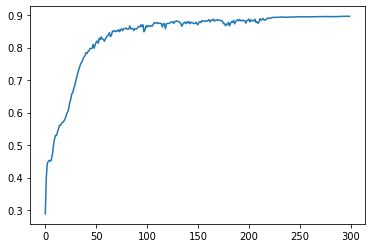

In [20]:
plt.plot(history['eval_acc'])

In [24]:
max(history['eval_acc'])

0.896286852657795

**Respuesta**

El modelo sin teacher forcing se demoró 2:41, mientras que este modelo se demoró 2:02, indicando que teacher forcing hacer el entrenamiento más rápido.

En termino de accuracy, ambos modelos logran un accuracy de un 90%, lo cual indica que ambos son buenos modelos. Ambos convergen bastante rápido tambien.